<a href="https://colab.research.google.com/github/huzaiffff/lab/blob/ids/10_1_stacking_xgboost_logisticregression_withoriginaldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV

#metrics
from sklearn import model_selection,feature_selection,utils,ensemble,metrics

#over-sampling and under sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

#time
from time import time
import datetime

#ROC   09/12/2022 LiFan
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f1=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")

f2=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
#Wed benign

f3=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")
#Thur WebAttack

f41=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
f42=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
#Fri Benign DDos PortScan

f51=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")

f52=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")

f53=pd.read_csv("/content/drive/MyDrive/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")


In [ ]:
data=pd.concat((f1,f2))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(975827, 79)

In [ ]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975822,53,155,2,2,88,120,44,44,44.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
975823,59317,110,1,1,0,0,0,0,0.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
975824,53,166,2,2,88,188,44,44,44.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
975825,54726,81,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# too few samples in some subclasses of Web Attack, and they are combined into one class.
#Tuesday Brute Force
data[' Label'].replace("FTP-Patator","BruteForce",inplace=True,regex=True)
data[' Label'].replace("SSH-Patator","BruteForce",inplace=True,regex=True)
#Thursday Web Attack
data[' Label'].replace("Web Attack .*","Web Attack",inplace=True,regex=True)
#DoS 
data[' Label'].replace("DoS .*","DoS",inplace=True,regex=True)
data[' Label'].replace("DDoS","DoS",inplace=True,regex=True)

In [ ]:
target_count_new=data[' Label'].value_counts(0)
target_count_new

BENIGN        961992
BruteForce     13835
Name:  Label, dtype: int64

In [ ]:
labels_new,values_new=zip(*sorted(target_count_new.items()))

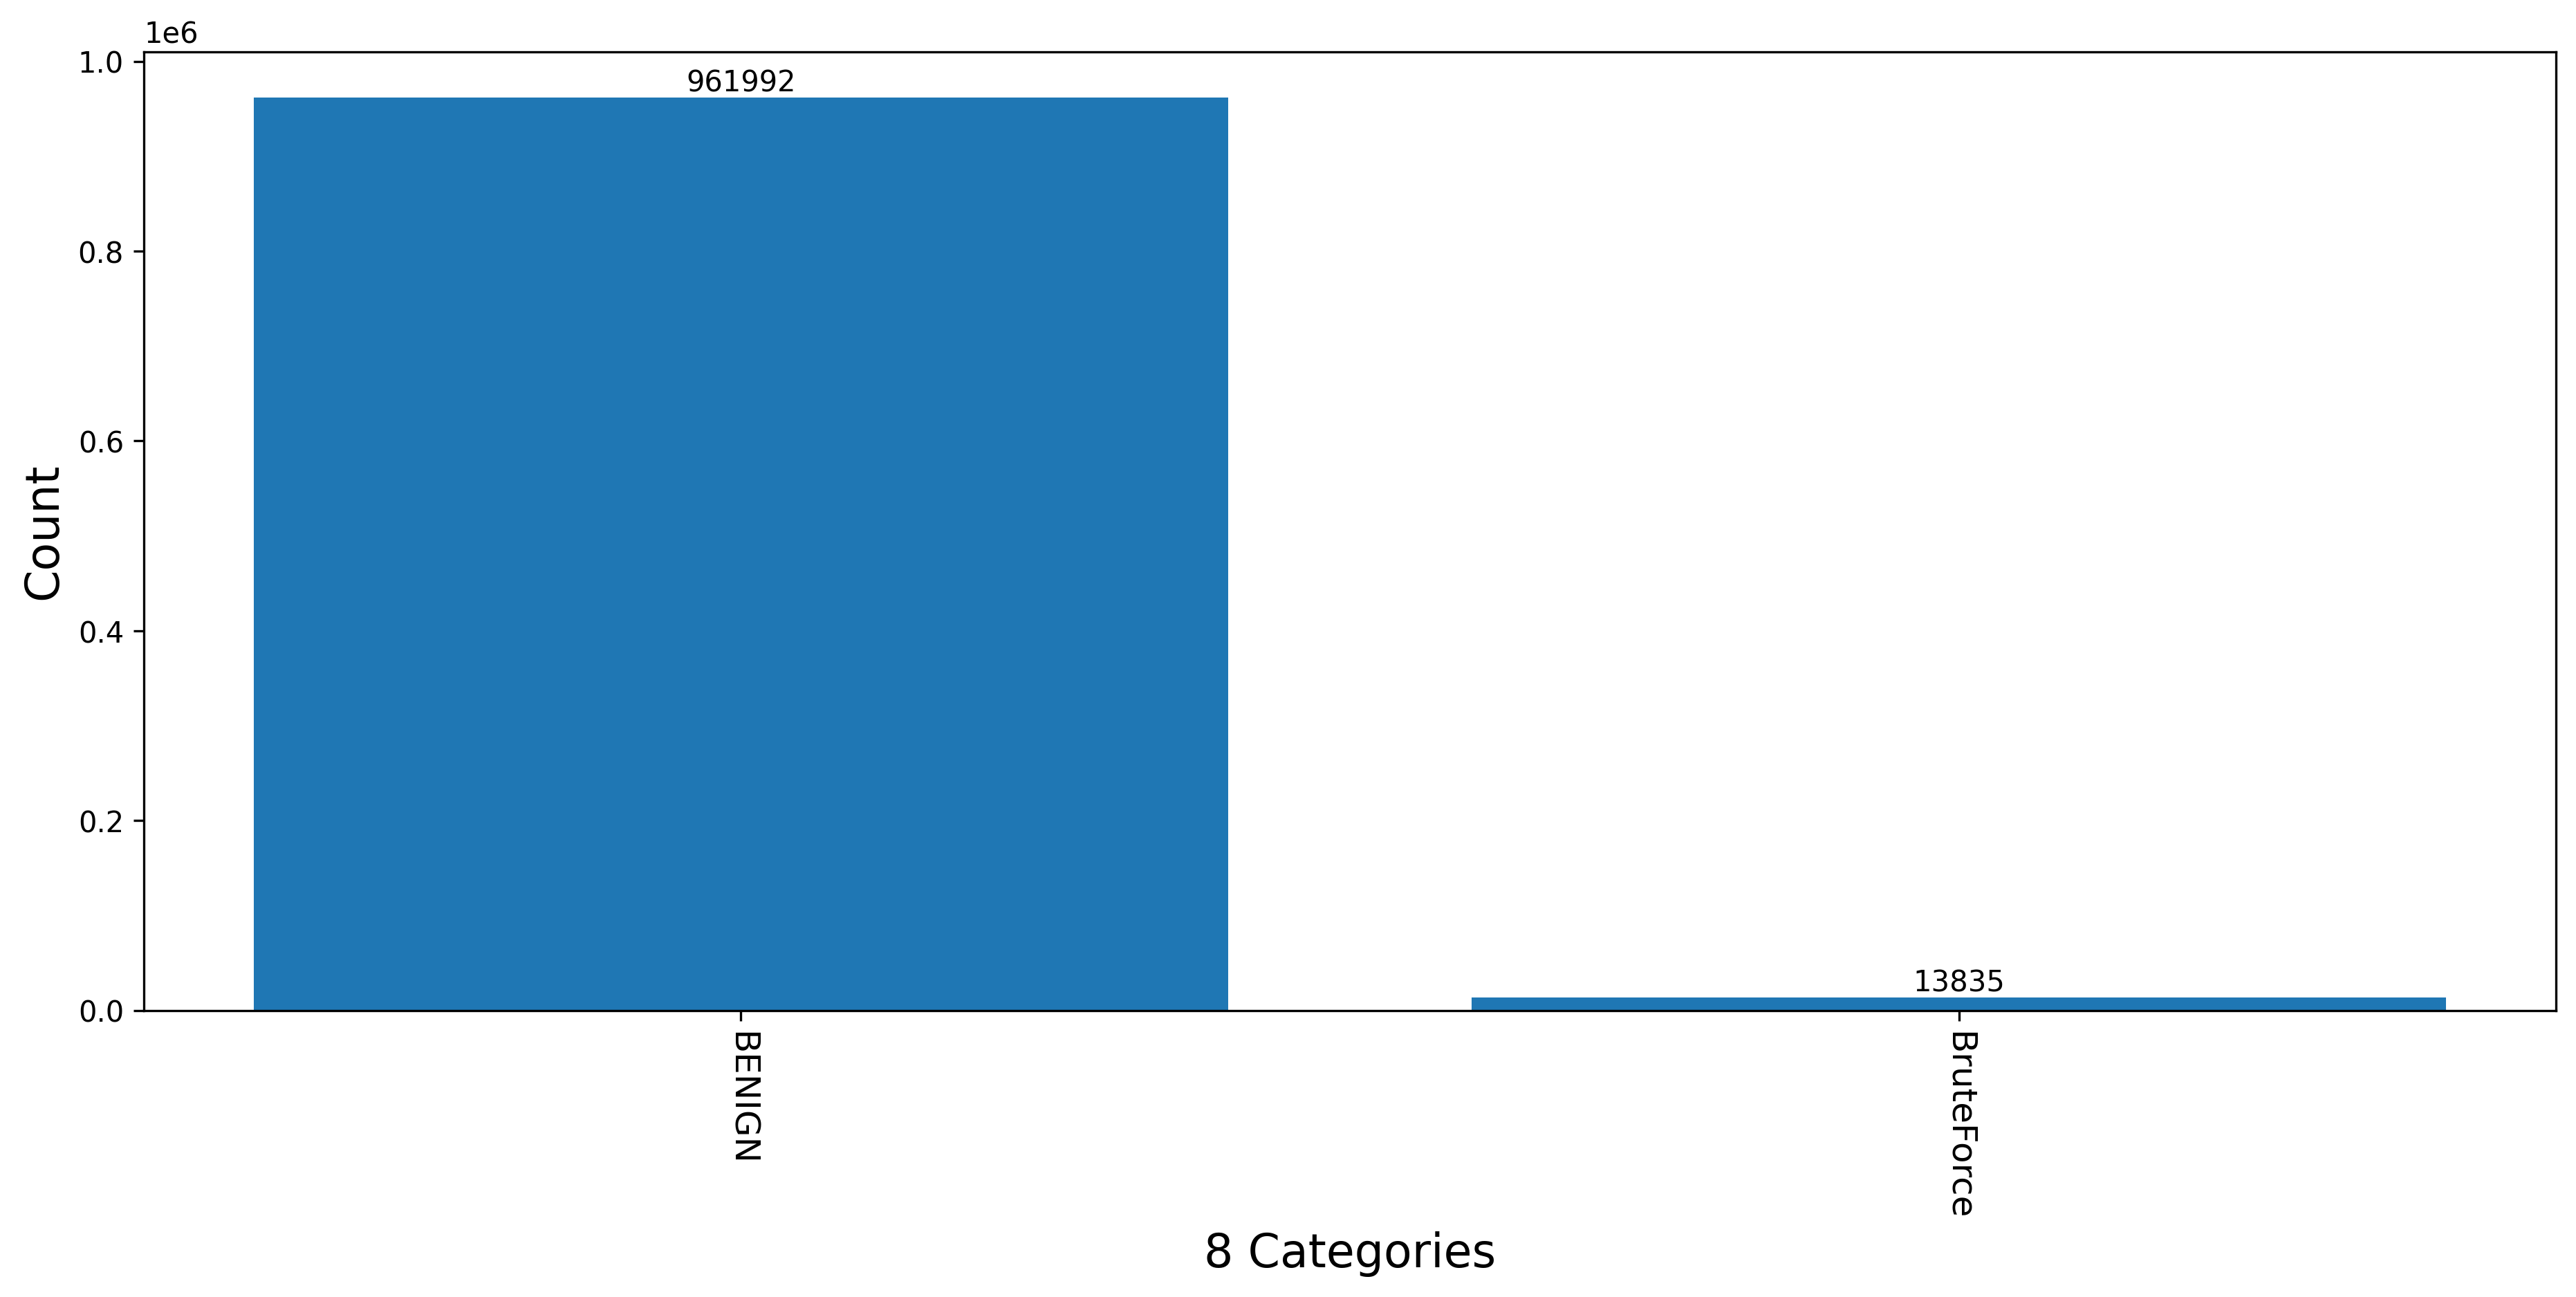

In [ ]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_new,values_new)
for x_new,y_new in zip(labels_new,values_new):
    plt.text(x_new,y_new,y_new,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=-90)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [ ]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [ ]:
data[' Label'].value_counts()

BENIGN        915076
BruteForce      9150
Name:  Label, dtype: int64

In [ ]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 915076, 'BruteForce': 9150})


In [ ]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 915076, 1: 9150})


In [ ]:
#Ram Clean
del data
gc.collect()

2823

In [ ]:
#3.2 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.95,random_state=42)
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

No. of training examples: 46211
No. of testing examples: 878015


In [ ]:
print(Counter(y_train))

Counter({0: 45731, 1: 480})


In [ ]:
#4. Training
#4.1 Estimators (level 0)

In [ ]:
rfc=RandomForestClassifier(random_state=12345)

In [ ]:
xtc=ExtraTreesClassifier(random_state=12345)

In [ ]:
gbc=GradientBoostingClassifier(n_estimators=10,random_state=123456)

In [ ]:
xgbc=XGBClassifier(n_estimators=100,random_state=12345)

In [ ]:
lgbc=LGBMClassifier(random_state=12345)

In [ ]:
cbc=CatBoostClassifier(random_state=12345)

In [ ]:
#estimators=[("GradientBoostingClassifier",gbc),("XgboostClassifier",xgbc),("LightGBM",lgbc),("CatBoostingClassifier",cbc)]
#estimators=[("XgboostClassifier",xgbc),("LightGBM",lgbc),("CatBoostingClassifier",cbc)]
estimators=[("XgboostClassifier",xgbc)]
#final_estimator=RandomForestClassifier(random_state=12345,n_jobs=-1)
final_estimator=LogisticRegressionCV(n_jobs=-1)

In [ ]:
#scv = StratifiedKFold(n_splits=5)

In [ ]:
clf=StackingClassifier(estimators=estimators,final_estimator=final_estimator)

In [ ]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Time of Training : 51.903 s


In [ ]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)


In [ ]:
y_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_train)).toarray()

In [ ]:
y_pred_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_train)).toarray()

In [ ]:
y_train_en,y_pred_train_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [ ]:
y_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()

In [ ]:
y_pred_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_test)).toarray()

In [ ]:
y_test_en,y_pred_test_en

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [ ]:
#5. Result 
#5.1 Train
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))


==Train==
[[45731     0]
 [    0   480]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45731
           1       1.00      1.00      1.00       480

    accuracy                           1.00     46211
   macro avg       1.00      1.00      1.00     46211
weighted avg       1.00      1.00      1.00     46211

Accuracy Score =  1.0
Precison       =  1.0
Recall         =  1.0
F1_score       =  1.0


In [ ]:
precision,recall,fscore,none= metrics.precision_recall_fscore_support(y_train, y_pred_train, average='weighted') 
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_train,y_pred_train))))
print('Weighted Precision : '+(str(precision)))
print('Weighted Recall    : '+(str(recall)))
print('Weighted F1-score  : '+(str(fscore)))

Accuracy Score     : 1.0
Weighted Precision : 1.0
Weighted Recall    : 1.0
Weighted F1-score  : 1.0


In [ ]:
#5.2 Test
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_test_en,y_pred_test_en,average='macro'))

==Test==
[[869262     83]
 [    17   8653]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    869345
           1       0.99      1.00      0.99      8670

    accuracy                           1.00    878015
   macro avg       1.00      1.00      1.00    878015
weighted avg       1.00      1.00      1.00    878015

Accuracy Score =  0.9989718707537194
Precison       =  0.9952397639060415
Recall         =  0.9989718707537194
F1_score       =  0.9970986689494725
Auc score      =  0.9989718707537194


In [ ]:
tprecision,trecall,tfscore,none= metrics.precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_test,y_pred_test))))
print('Weighted Precision : '+(str(tprecision)))
print('Weighted Recall    : '+(str(trecall)))
print('Weighted F1-score  : '+(str(tfscore)))

Accuracy Score     : 0.9998861067293839
Weighted Precision : 0.9998868194389785
Weighted Recall    : 0.9998861067293839
Weighted F1-score  : 0.9998863204976496


In [ ]:
#6.1 Init
class_names=['BENIGN','Bot','BruteForce','DoS','Heartbleed','Infiltration','PortScan','Web Attack']
colors=['black','darkorange','forestgreen','navy','red','olive','darkcyan','deeppink']
linestyles=['-','--','-.',':','-','--','-.',':']
num_class=len(class_names)
fpr, tpr, roc_auc = dict(), dict(), dict()

In [ ]:
#6.2 fpr tpr 
for i in range(num_class):
    fpr[i],tpr[i],_=roc_curve(y_test_en[:,i],y_pred_test_en[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
fpr_grid=np.linspace(0.0,1.0,1000)

mean_tpr=np.zeros_like(fpr_grid)
for i in range(num_class):
    mean_tpr+=np.interp(fpr_grid,fpr[i],tpr[i])#linear interpolation

mean_tpr/=num_class
fpr["macro"]=fpr_grid
tpr["macro"]=mean_tpr
roc_auc["macro"]=auc(fpr["macro"],tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.6f}")

IndexError: ignored

KeyError: ignored

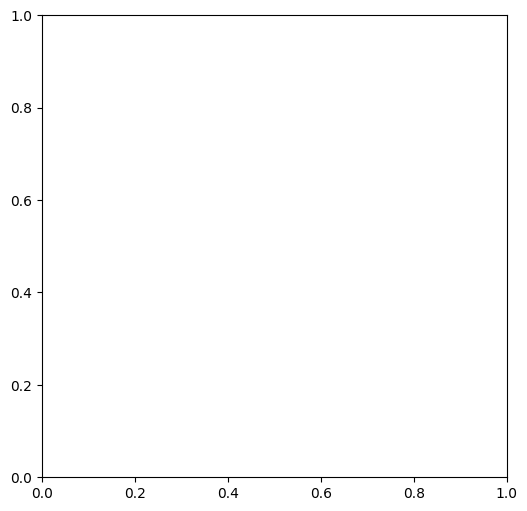

In [ ]:
#6.3 Display
fig,ax=plt.subplots(figsize=(6,6))
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC={roc_auc['macro']:.6f})",
    linestyle=":",
    linewidth=4,
)
for i in range(num_class):
    RocCurveDisplay.from_predictions(
    y_test_en[:,i],
    y_pred_test_en[:,i],
    name=f"ROC curve for {class_names[i]}",
    color=colors[i],
    linestyle=linestyles[i],
    ax=ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("False Positive Rate",fontsize=12)
plt.ylabel("True Positive Rate",fontsize=12)
plt.title("Stacking \n One-vs-Rest multiclass",fontsize=14)
plt.legend(fontsize=11)
plt.show()

### Xgboost + LogisticRegression (Original Data)
Accuracy Score =  0.9494163118894287  
Precison       =  0.9817017338340577  
Recall         =  0.9494163118894287  
F1_score       =  0.9641099573831886  
Auc score      =  0.9745784207103945  